Code for **"Blind restoration of a JPEG-compressed image"** and **"Blind image denoising"** figures. Select `fname` below to switch between the two.

- To see overfitting set `num_iter` to a large value.

# Import libs

In [1]:
# !wget clone https://github.com/DmitryUlyanov/deep-image-prior
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import os
os.chdir("/content/gdrive/My Drive/Colab Notebooks/deep-image-prior-master")

Mounted at /content/gdrive


In [0]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from common import *
from dcgan import *
from downsampler import *
from resnet import *
from skip import *
from texture_nets import *
from unet import *

import torch
import torch.optim

from skimage.measure import compare_psnr
from utils.denoising_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize =-1
PLOT = True
sigma = 25
sigma_ = sigma/255.

In [0]:
# deJPEG 
# fname = 'data/denoising/snail.jpg'

## denoising
#fname = 'data/denoising/F16_GT.png'
fname = 'data/denoising/13_gau.jpg'

# Load image

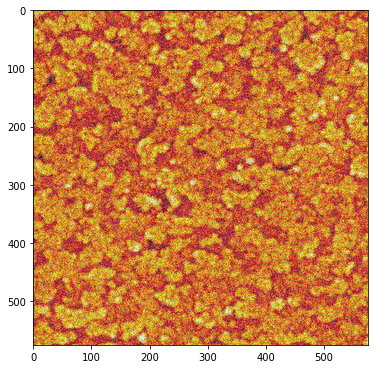

In [4]:
if fname == 'data/denoising/snail.jpg':
    img_noisy_pil = crop_image(get_image(fname, imsize)[0], d=32)
    img_noisy_np = pil_to_np(img_noisy_pil)
    
    # As we don't have ground truth
    img_pil = img_noisy_pil
    img_np = img_noisy_np
    
    if PLOT:
        plot_image_grid([img_np], 4, 5);
        
elif fname == 'data/denoising/F16_GT.png':
    # Add synthetic noise
    img_pil = crop_image(get_image(fname, imsize)[0], d=32)
    img_np = pil_to_np(img_pil)
    
    img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)
    
    if PLOT:
        plot_image_grid([img_np, img_noisy_np], 4, 6);
else:
    img_noisy_pil = crop_image(get_image(fname, imsize)[0], d=32)
    img_noisy_np = pil_to_np(img_noisy_pil)
    
    # As we don't have ground truth
    img_pil = img_noisy_pil
    img_np = img_noisy_np
    
    if PLOT:
        plot_image_grid([img_np], 4, 5);

In [0]:
import cv2

def noisy(noise_typ,image):
  if noise_typ == "gauss":
    row,col,ch= image.shape
    mean = 0
    var = 0.01
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss
    return noisy
  
  elif noise_typ == "s&p":
    row,col,ch = image.shape
    s_vs_p = 0.5
    amount = 0.04
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
    out[coords] = 1

    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
    out[coords] = 0
    return out
  
  elif noise_typ == "poisson":
    vals = len(np.unique(image))
    vals = 2 ** np.ceil(np.log2(vals))
    noisy = np.random.poisson(image * vals) / float(vals)
    return noisy
  
  elif noise_typ =="speckle":
    row,col,ch = image.shape
    gauss = np.random.randn(row,col,ch)
    gauss = gauss.reshape(row,col,ch)        
    noisy = image + image * gauss
    return noisy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


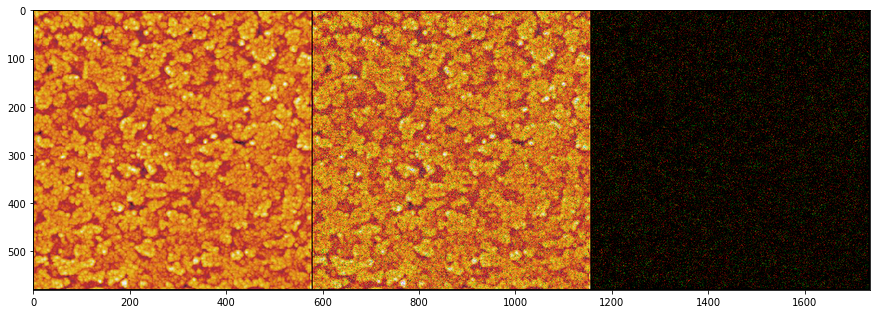

In [0]:
nos_img_np = noisy("s&p",img_np)
plot_image_grid([img_np, nos_img_np,img_np-nos_img_np], 4, 12);

In [0]:
import matplotlib
nos_img_np_out = nos_img_np.transpose(1,2,0)
matplotlib.image.imsave('de1_s&p.png', nos_img_np_out)

In [0]:
img_noisy_pil.shape

AttributeError: ignored

# Setup

In [0]:
from skip import skip
from texture_nets import get_texture_nets
from resnet import ResNet
from unet import UNet

import torch.nn as nn

def get_net(input_depth, NET_TYPE, pad, upsample_mode, n_channels=3, act_fun='LeakyReLU', skip_n33d=128, skip_n33u=128, skip_n11=4, num_scales=5, downsample_mode='stride'):
    if NET_TYPE == 'ResNet':
        # TODO
        net = ResNet(input_depth, 3, 10, 16, 1, nn.BatchNorm2d, False)
    elif NET_TYPE == 'skip':
        net = skip(input_depth, n_channels, num_channels_down = [skip_n33d]*num_scales if isinstance(skip_n33d, int) else skip_n33d,
                                            num_channels_up =   [skip_n33u]*num_scales if isinstance(skip_n33u, int) else skip_n33u,
                                            num_channels_skip = [skip_n11]*num_scales if isinstance(skip_n11, int) else skip_n11, 
                                            upsample_mode=upsample_mode, downsample_mode=downsample_mode,
                                            need_sigmoid=True, need_bias=True, pad=pad, act_fun=act_fun)

    elif NET_TYPE == 'texture_nets':
        net = get_texture_nets(inp=input_depth, ratios = [32, 16, 8, 4, 2, 1], fill_noise=False,pad=pad)

    elif NET_TYPE =='UNet':
        net = UNet(num_input_channels=input_depth, num_output_channels=3, 
                   feature_scale=4, more_layers=0, concat_x=False,
                   upsample_mode=upsample_mode, pad=pad, norm_layer=nn.BatchNorm2d, need_sigmoid=True, need_bias=True)
    elif NET_TYPE == 'identity':
        assert input_depth == 3
        net = nn.Sequential()
    else:
        assert False

    return net

In [6]:
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 1./30. # set to 1./20. for sigma=50
LR = 0.02

OPTIMIZER='adam' # 'LBFGS'
show_every = 100
exp_weight=0.99

if fname == 'data/denoising/snail.jpg':
    num_iter = 2400
    input_depth = 3
    figsize = 5 
    
    net = skip(
                input_depth, 3, 
                num_channels_down = [8, 16, 32, 64, 128], 
                num_channels_up   = [8, 16, 32, 64, 128],
                num_channels_skip = [0, 0, 0, 4, 4], 
                upsample_mode='bilinear',
                need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU')

    net = net.type(dtype)

elif fname == 'data/denoising/F16_GT.png':
    num_iter = 3000
    input_depth = 32 
    figsize = 4 
    
    
    net = get_net(input_depth, 'skip', pad,
                  skip_n33d=128, 
                  skip_n33u=128, 
                  skip_n11=4, 
                  num_scales=5,
                  upsample_mode='bilinear').type(dtype)

else:
    num_iter = 5000
    input_depth = 3
    figsize = 5 
    
    net = skip(
                input_depth, 3, 
                num_channels_down = [8, 16, 32, 64, 128], 
                num_channels_up   = [8, 16, 32, 64, 128],
                num_channels_skip = [0, 0, 0, 4, 4], 
                upsample_mode='bilinear',
                need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU')

    net = net.type(dtype)
    
net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)

Number of params: 572827


# Optimize

In [0]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0

i = 0
def closure():
    
    global i, out_avg, psrn_noisy_last, last_net, net_input
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_input)
    
    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)
            
    total_loss = mse(out, img_noisy_torch)
    total_loss.backward()
        
    
    psrn_noisy = compare_psnr(img_noisy_np, out.detach().cpu().numpy()[0]) 
    psrn_gt    = compare_psnr(img_np, out.detach().cpu().numpy()[0]) 
    psrn_gt_sm = compare_psnr(img_np, out_avg.detach().cpu().numpy()[0]) 
    
    # Note that we do not have GT for the "snail" example
    # So 'PSRN_gt', 'PSNR_gt_sm' make no sense
    print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1), 
                         np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=1)
        
        
    
    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5: 
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy
            
    i += 1

    return total_loss

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

Output hidden; open in https://colab.research.google.com to view.

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


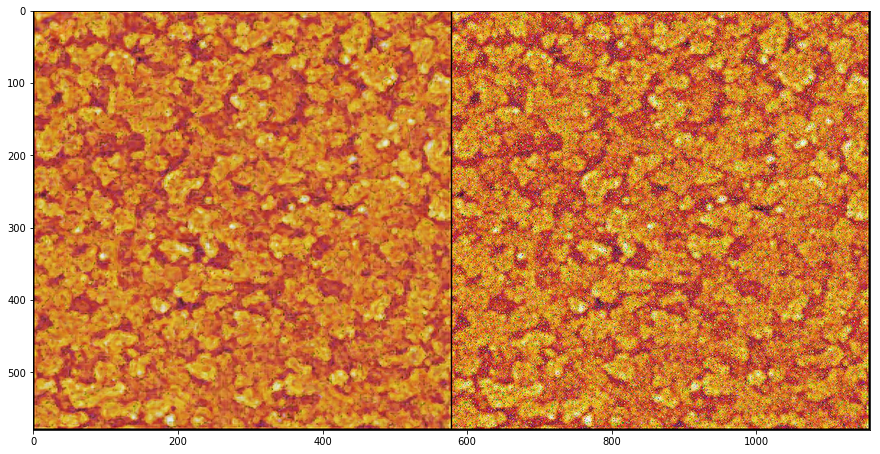

In [12]:
out_np = torch_to_np(net(net_input))
q = plot_image_grid([np.clip(out_np, 0, 1), img_np], factor=13);

In [0]:
import matplotlib
out_np_w = out_np.transpose(1,2,0)

matplotlib.image.imsave('de5_out.png', out_np_w)